In [1]:
from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import random as r
from datetime import datetime
import requests
from numpy.polynomial.polynomial import Polynomial
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

Change the following line of code to any valid ticker of your choice!

In [3]:
#Get ticker, ticker can be changed to any ticker
ticker = yf.Ticker("^GSPC")

The following is attempting to predict the stock using historical data through using a polynomal regression such that the R^2 value of the regression is above 0.9.

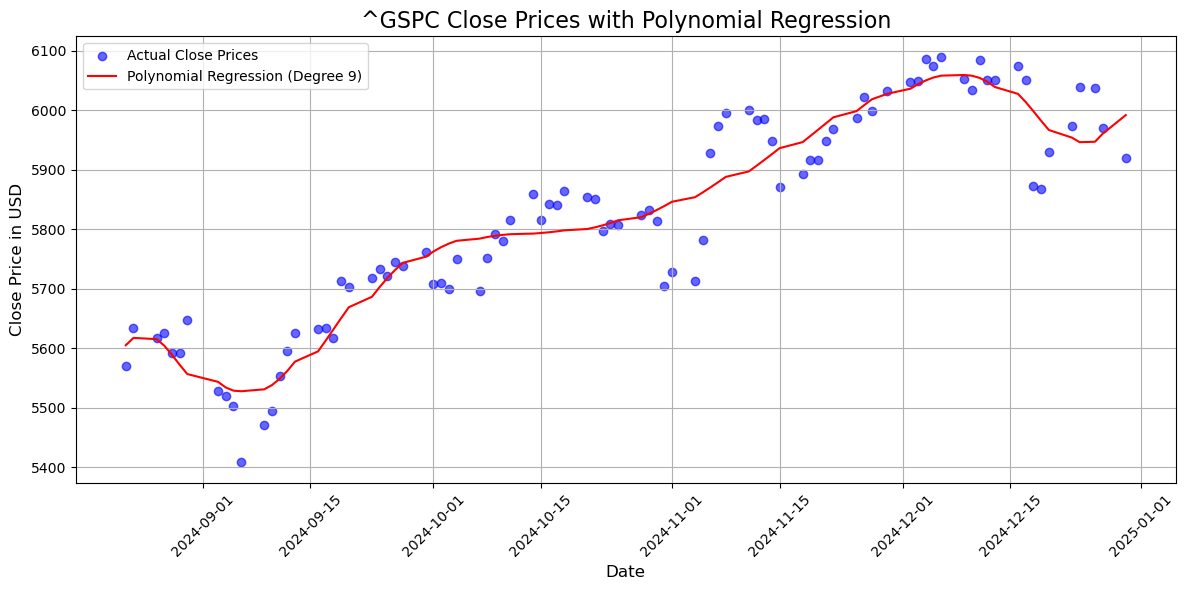

In [5]:
#Store last 90 days 
data = ticker.history(period="1y")[['Close']].tail(90)
data.index = data.index.date

# Ready for regression
X = np.arange(len(data))  
y = data['Close'].values

# Initialize and create first loop
degree = 1
coefs = np.polyfit(X, y, degree)
poly_model = np.poly1d(coefs)
y_pred = poly_model(X)

# Iteratively increase degree until R^2 >= 0.9
r2 = r2_score(y, y_pred)
while r2 < 0.9:
    degree += 1
    coefs = np.polyfit(X, y, degree)
    poly_model = np.poly1d(coefs)
    y_pred = poly_model(X)
    r2 = r2_score(y, y_pred)

# Plot the data and regression curve
plt.figure(figsize=(12, 6))
plt.scatter(data.index, y, color='blue', label='Actual Close Prices', alpha=0.6)
plt.plot(data.index, y_pred, color='red', label=f'Polynomial Regression (Degree {degree})')
plt.title(ticker.ticker+" Close Prices with Polynomial Regression", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price in "+ str(ticker.info['currency']), fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

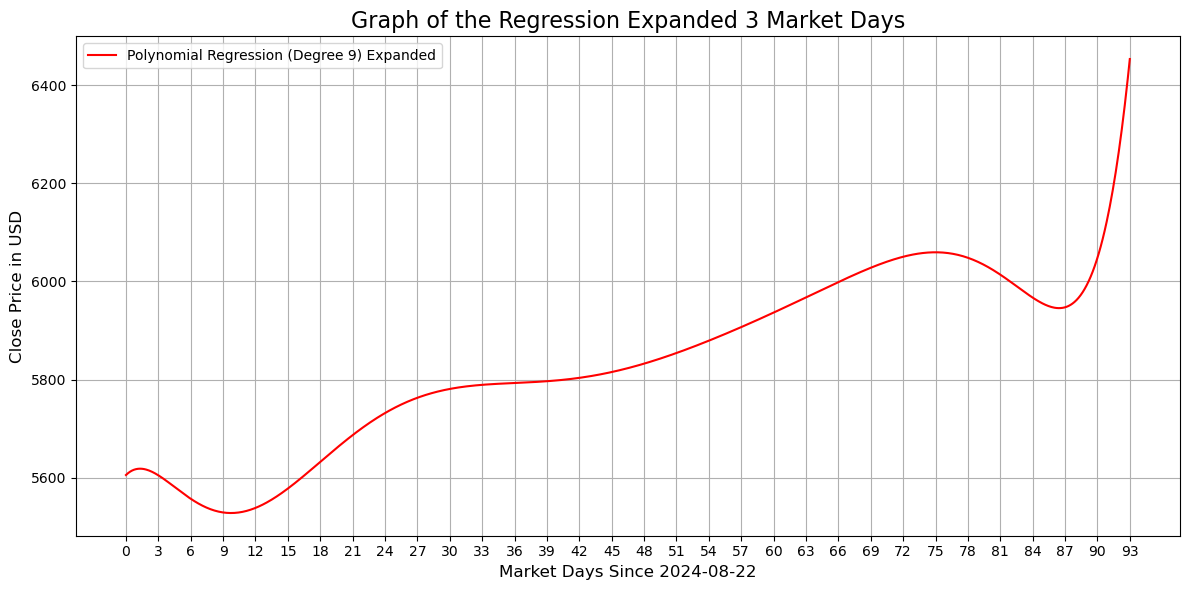

In [6]:
#Create function
poly_function = np.poly1d(coefs)

# Ready the x and y axis
x = np.linspace(0, 93, 1000)
y = poly_function(x)

# Plot the polynomial
plt.figure(figsize=(12, 6))
plt.plot(x, y, label= f'Polynomial Regression (Degree {degree}) Expanded', color="red")
#plt.axhline(5400, color="black", linestyle="--", linewidth=1)  # Add x-axis
#plt.axvline(0, color="black", linestyle="--", linewidth=1)  # Add y-axis
plt.title("Graph of the Regression Expanded 3 Market Days", fontsize=16)
plt.xlabel("Market Days Since "+ str(data.index[0]), fontsize=12)
plt.ylabel("Close Price in "+ str(ticker.info['currency']), fontsize=12)
plt.xticks(np.arange(0, 95, 3))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
#Print close prices
print("The close price of "+ticker.ticker+" on the next market day is predicted to be: $"+str(poly_function(91)))
print("The close price of "+ticker.ticker+" on two market days from now is predicted to be: $"+str(poly_function(92)))
print("The close price of "+ticker.ticker+" on three market days from now is predicted to be: $"+str(poly_function(93)))

The close price of ^GSPC on the next market day is predicted to be: $6136.72311432338
The close price of ^GSPC on two market days from now is predicted to be: $6267.8828047565285
The close price of ^GSPC on three market days from now is predicted to be: $6453.345050146514


I chose to try this model because it was a great way to implement code to my research project as it would be able to adapt to different sets of data/stocks by changing the degree and fitting it to a specific R^2 value.

Although the regressions seems to fit the data well, I do not believe the model can be used to predict future prices. This is because trying to predict a stock's behavior using high-degree polynomial regression to achieve an R^2 > 0.9 is not a good idea because it likely leads to overfitting. Overfitting means that the model captures noise or short-term fluctuations in the historical data well, but it sacrifices the underlying trends, making it overly complex and less generalizable. While the model may fit the training data exceptionally well, it will struggle to perform accurately on new, unseen data due to the unpredictable and non-linear nature of stock prices, which are influenced by countless factors like market sentiment, news, and macroeconomic events. Additionally, stocks do not follow deterministic patterns that can be perfectly captured by a mathematical function, as their movements are often driven by random and chaotic processes. As a result, relying on such a model for predictions would likely lead to poor real-world performance. 

Going back to my research project, I stated that xsin(x) was a good way to model a stock because of the cyclical nature of a stock price and the fact that it grows and decays over time. This allows us to model a stock without overfitting the noise which happens in between. However, this model essentially creates higher volatility in the stock as x increases (as market days go on). This isn't necessarily true for all stocks, nor is it a generalizable trend. A trend is that businesses/stocks/indexes want to grow. While they grow, however, there is cyclical noise that occurs. As a result, a better way to model a stock price is through x + sin(x). x shows the increasing nature while sin(x) captures the noise that occurs. By adding variable parameters, we arrive at ax + bsin(c(x - d)) + f. The following attempts to predict the stock using historical data through using a regression of the model formula mentioned above, regardless of the R^2 value.

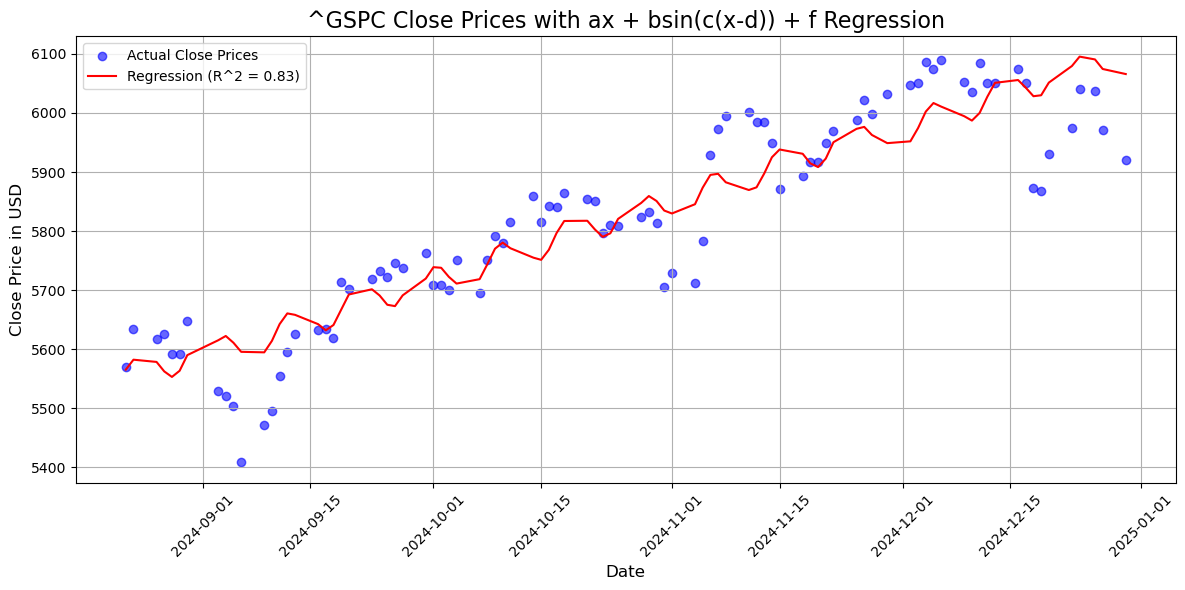

In [9]:
# Prepare the data
X = np.arange(len(data))  # Numeric index for regression
y = data['Close'].values  # Close prices

# Define the ax + bsin(c(x-d)) + f model
def ax_bsin_cxd_f(x, a, b, c, d, f):
    return a * x + b * np.sin(c * (x - d)) + f

#Guess the number of periods first
c=1
#Initial guess of the model
initial_guess = [0.5, (np.max(y) - np.min(y)) / 2, c, 0, np.mean(y)]

# Fit the model
params, params_covariance = curve_fit(ax_bsin_cxd_f, X, y, p0=initial_guess, maxfev=1000000)

# Extract the fitted parameters
a, b, c, d, f = params

# Generate predictions
y_pred = ax_bsin_cxd_f(X, a, b, c, d, f)

# Calculate R^2
r2 = r2_score(y, y_pred)

#Change the guess of number of periods such that the regression can somewhat model the trend
#This affects how much noise is seen in the model, differs between stocks/industries
for i in range(10):
    if (r2 < 0.6):
        initial_guess = [0.5, (np.max(y) - np.min(y)) / 2, c-(0.1*i), 0, np.mean(y)]
        params, params_covariance = curve_fit(ax_bsin_cxd_f, X, y, p0=initial_guess, maxfev=1000000)
        a, b, c, d, f = params
        y_pred = ax_bsin_cxd_f(X, a, b, c, d, f)
        r2 = r2_score(y, y_pred)

# Plot the data and regression curve
plt.figure(figsize=(12, 6))
plt.scatter(data.index, y, color='blue', label='Actual Close Prices', alpha=0.6)
plt.plot(data.index, y_pred, color='red', label=f'Regression (R^2 = {r2:.2f})')
plt.title(ticker.ticker + " Close Prices with ax + bsin(c(x-d)) + f Regression", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price in " + str(ticker.info['currency']), fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

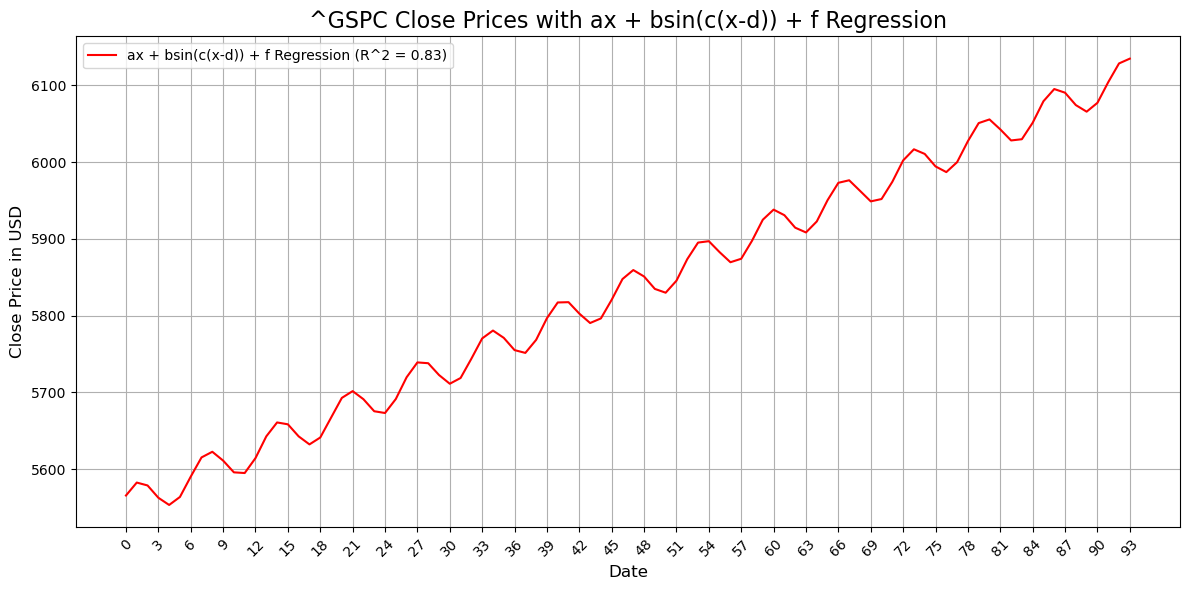

In [10]:
# Ready the x and y axis
X_new = np.arange(len(data)+4) 
y_pred2 = ax_bsin_cxd_f(X_new, a, b, c, d, f)


plt.figure(figsize=(12, 6))
plt.plot(X_new, y_pred2, color='red', label=f'ax + bsin(c(x-d)) + f Regression (R^2 = {r2:.2f})')
plt.title(ticker.ticker + " Close Prices with ax + bsin(c(x-d)) + f Regression", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price in " + str(ticker.info['currency']), fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(np.arange(0, 95, 3))
plt.show()

In [11]:
#Print close prices
print("The close price of "+ticker.ticker+" on the next market day is predicted to be: $"+str(ax_bsin_cxd_f(91, a, b, c, d, f)))
print("The close price of "+ticker.ticker+" on two market days from now is predicted to be: $"+str(ax_bsin_cxd_f(92, a, b, c, d, f)))
print("The close price of "+ticker.ticker+" on three market days from now is predicted to be: $"+str(ax_bsin_cxd_f(93, a, b, c, d, f)))

The close price of ^GSPC on the next market day is predicted to be: $6104.288840783527
The close price of ^GSPC on two market days from now is predicted to be: $6128.74555561196
The close price of ^GSPC on three market days from now is predicted to be: $6134.985716631347


This model more accurately follows the general trends of stocks, the desire to increase, and the noise that occurs throughout market days. Still, there are limitations. While it captures broad trends (x) and periodic fluctuations (sin(x)), it oversimplifies the highly complex and random nature of stock price movements. Compared to high-degree polynomial regression, it avoids overfitting and provides a more interpretable framework, but it lacks the flexibility to adapt to the erratic and non-cyclic nature of real stock data, which is influenced by unpredictable events and sentiment-driven volatility. Its strength is that it follows generalizable trends of stocks rather than overfitting, but its weakness is that it imposes a rigid structure, assuming consistent periodic behavior and a linear trend—neither of which aligns with the stochastic and often nonlinear characteristics of stock markets. As a result, it is insufficient for accurate prediction in a domain as dynamic and complex as stock prices.  

As I've seen in my research and attempted to improve/expand said research with code, it is not suitable to create a generalizable model using simple mathematical functions. The market has a vast number of variables affecting it, and attempting to model and predict the stock price based solely on its historical prices is naive. However, the model could be more successful if all else remained constant and could attempt to capture simple buying and selling equilibriums along with firm growth. Nonetheless, this research has shown me some trends that many businesses follow but also the unpredictable nature of the market, which requires more research to tackle and perhaps is not generalizable to all stocks.  

Some ideas to expand again in the future: I would like to tackle and research specific variables that influence stock prices. Such a model could analyze new information on a stock, decide whether it is good or bad for the stock (through prior research), and deliver an output to the user. A challenge may be predicting the specific price the stock would end up at, but that doesn't necessarily need to happen—perhaps a simple "stock will decrease/increase tomorrow" could be a suitable approach. 